In [1]:
from qspmodel import *
from chemo_qspmodel import *
import pandas as pd
import csv
import os
import scipy as sp

if not os.path.exists('Results/'):
    os.makedirs('Results/All_Dynamic/')
else:
    if not os.path.exists('Results/All_Dynamic/'):
        os.makedirs('Results/All_Dynamic/')


# some global parameters
clusters=3 #number of clusters

#number_of_cycles=6
cycle_time=35
n_cycles=2

start_treatment = 7
T=200
t=np.linspace(0, T, 2001)

# pre-defined parameters for treatment deltas, typical drug_dose
drug_deltas=[1.4466, 8.3178, 39.9253]
baseline_drug_dose=[381.90955, 1.19347, 1.90955]
drug_dose=[381.90955, 1.19347, 1.90955]


# create parameters for step function 
A1infusion = [np.array([21, 127/6]),  np.array([28, 169/6])]
A2infusion = [np.array([0, 1/6]), np.array([1, 7/6])]
A3infusion = [np.array([0, 1/6]), np.array([1, 7/6])]
infusion_idx = np.concatenate([15*np.ones(n_cycles*len(A1infusion)), 16*np.ones(n_cycles*len(A2infusion)), 
                               17*np.ones(n_cycles*len(A3infusion))]).astype(int)

infusion_vals = np.concatenate([(drug_dose[0]/baseline_drug_dose[0])*drug_deltas[0]/(A1infusion[0][1] - A1infusion[0][0])*np.ones(n_cycles*len(A1infusion)),
                                (drug_dose[1]/baseline_drug_dose[1])*drug_deltas[1]/(A2infusion[0][1] - A2infusion[0][0])*np.ones(n_cycles*len(A2infusion)),
                                (drug_dose[2]/baseline_drug_dose[2])*drug_deltas[2]/(A3infusion[0][1] - A3infusion[0][0])*np.ones(n_cycles*len(A3infusion))])

infusion_intervals = np.concatenate([[start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A1infusion],
                                     [start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A2infusion],
                                     [start_treatment+i*cycle_time+j for i in range(n_cycles) for j in A3infusion]])


#other parameters
nvar=OS_MAP_resistant_Functions().nvar # number of variables
nparam=OS_MAP_resistant_Functions().nparam # number of parameters


In [2]:
print(infusion_intervals)
print(infusion_idx)
print(infusion_vals)

# infusion function
r= step_vector(nvar, indices=infusion_idx, intervals=infusion_intervals, values=infusion_vals)

[[28.         28.16666667]
 [35.         35.16666667]
 [63.         63.16666667]
 [70.         70.16666667]
 [ 7.          7.16666667]
 [ 8.          8.16666667]
 [42.         42.16666667]
 [43.         43.16666667]
 [ 7.          7.16666667]
 [ 8.          8.16666667]
 [42.         42.16666667]
 [43.         43.16666667]]
[15 15 15 15 16 16 16 16 17 17 17 17]
[  8.6796   8.6796   8.6796   8.6796  49.9068  49.9068  49.9068  49.9068
 239.5518 239.5518 239.5518 239.5518]


In [3]:
clustercells = pd.read_csv('input/TARGET_steady_states.csv')
clustercells.drop('Unnamed: 0', axis=1, inplace=True)
clustercells = clustercells.to_numpy()

meanvals = pd.read_csv('input/TARGET_avg_by_cluster.csv')
meanvals.drop('Unnamed: 0', axis=1, inplace=True)
meanvals = meanvals.to_numpy()

In [4]:
# Initial conditions with steady state tumors
IC = np.ones((3, 14))
IC = np.concatenate([IC, np.zeros((3,3))], axis=1)
IC

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0.]])

In [5]:
def plot_dynamics(name='-results-', cutoff=200, savefig=False, figname=None):

    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    import seaborn as sns

    dynamic_all = []
    for c in [1,2,3]:
        filename='Cluster-'+str(c)+name
        dat = pd.read_csv('Results/All_Dynamic/'+filename+'dat.csv')
        dat.drop(dat.columns[-3:], axis=1, inplace=True)
        dat['Total cells'] = dat[dat.columns[1:-4]].sum(axis=1)
        dat['Cluster'] = c
        print('Cancer population left: ', dat[dat['time (days)']==80]['Cancer cells  ($C$)'])
        dynamic_all.append(dat)

    dynamic_all_df = pd.concat(dynamic_all, axis=0)
    dynamic_all_df = dynamic_all_df[dynamic_all_df['time (days)'] < cutoff]

    palette={'Cluster 1':'#3F9B0B', 'Cluster 2':'#FF796C', 'Cluster 3':'#0343DF'}
    dynamic_all_df['Cluster'] = dynamic_all_df['Cluster'].apply(lambda x: 'Cluster '+str(x))
    custom_lines = [Line2D([0], [0], color='#3F9B0B', lw=1.5), 
                    Line2D([0], [0], color='#FF796C', lw=1.5),
                    Line2D([0], [0], color='#0343DF', lw=1.5)]

    fig, axs = plt.subplots(3, 5, sharey=False, figsize=(21,12))
    fig.subplots_adjust(wspace=0.37, hspace=0.37)
    axs = axs.flatten()
    plt.rcParams.update({'font.size': 14})

    for i, col in enumerate(dynamic_all_df.columns[1:-1]):
        sns.lineplot(data=dynamic_all_df, x='time (days)', y=col, hue='Cluster', palette=palette, ax=axs[i], legend=False)
        axs[i].margins(x=0)
        if i != 5: axs[i].set_ylim(bottom=0)

    axs[9].legend(custom_lines, ['Cluster 1', 'Cluster 2', 'Cluster 3'], bbox_to_anchor=(1.08, 0.5), loc='center left')

    if savefig:
        if not figname: figname = filename
        fig.savefig('Figures/'+figname+'.png', bbox_inches='tight')   
        fig.savefig('Figures/'+figname+'.pdf', bbox_inches='tight')   
        fig.savefig('Figures/'+figname+'.eps', bbox_inches='tight')   
    plt.show()

#### DOX-resistant tumor cells

In [6]:
#Computations of dynamics
print('Starting dynamics computations')


betasI = [2.4780, 1.8328, 0.1467]
betasC = [2.4780, 0.2845, 0.1467]
K_C = 0.9
K_immune = 0.6
a = 16
alphaNCA = 0.8
deltaCTcA3_scale = 1


for cluster in range(clusters):
    print('Starting computations for cluster '+str(cluster+1)) 
    filename='Cluster-'+str(cluster+1)+'-results-DOX-resistant-'

    QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    qspcore=OS_MAP_resistant_Functions(parameters=QSP0.par)
    deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale
    print(QSP0.par[37], deltaCTcA3)
    QSP_=QSP.from_data(([drug_deltas, betasI, betasC, K_C, K_immune, a, alphaNCA, deltaCTcA3, drug_dose, clustercells[cluster]]), qspcore=qspcore)
    
    print(' Parameters set. Computing the solution')

    u, _ = QSP_.solve_ode(t, IC[cluster], 'given', inhomogeneity=r, jumps=True)
    # Add last 3 equations scaling value
    scale = np.concatenate([clustercells[cluster], np.array(drug_dose)/np.array(drug_deltas)])
    u = scale*u
    
    wr=np.empty((t.size, 18))
    wr[:,0]=t
    wr[:,1:]=u
    c=csv.writer(open('Results/All_Dynamic/'+filename+'dat.csv',"w")) 
    c.writerow(['time (days)']+QSP_.variable_names())
    c.writerows(wr)
    del c


Starting dynamics computations
Starting computations for cluster 1
0.012269443384292386 0.012269443384292386
 Parameters set. Computing the solution


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Starting computations for cluster 2
0.009657389749427571 0.009657389749427571
 Parameters set. Computing the solution
Starting computations for cluster 3
0.008401675631568845 0.008401675631568845
 Parameters set. Computing the solution


Cancer population left:  800    3.817479e+09
Name: Cancer cells  ($C$), dtype: float64
Cancer population left:  800    4.319284e+09
Name: Cancer cells  ($C$), dtype: float64
Cancer population left:  800    3.225779e+09
Name: Cancer cells  ($C$), dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


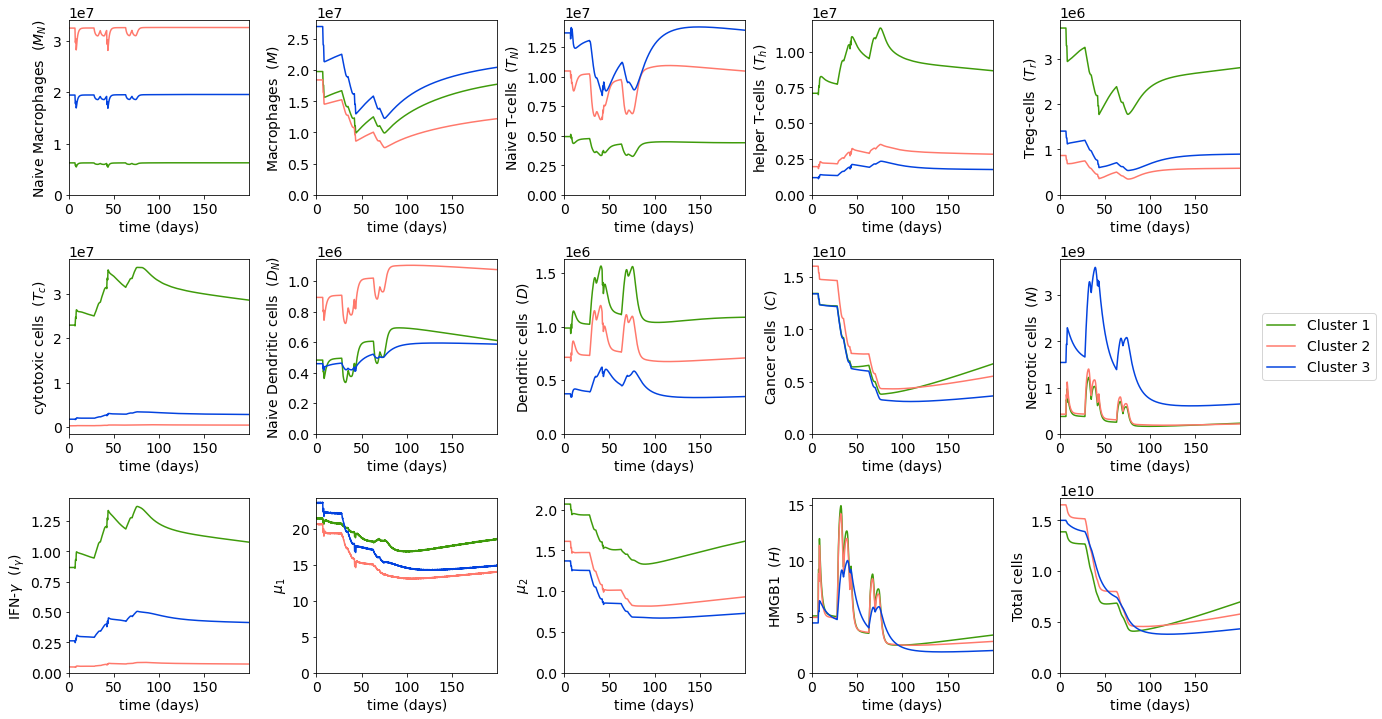

In [12]:
plot_dynamics(name='-results-DOX-resistant-', cutoff=200, savefig=True, figname='Dynamics_DOX_resistant')

#### CDDP-resistant

In [8]:
#Computations of dynamics
print('Starting dynamics computations')


betasI = [2.4780, 1.8328, 0.1467]
betasC = [2.4780, 1.8328, 0.0133]
K_C = 0.9
K_immune = 0.6
a = 16
alphaNCA = 0.8
deltaCTcA3_scale = 1


for cluster in range(clusters):
    print('Starting computations for cluster '+str(cluster+1)) 
    filename='Cluster-'+str(cluster+1)+'-results-CDDP-resistant-'

    QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    qspcore=OS_MAP_resistant_Functions(parameters=QSP0.par)
    deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale
    print(QSP0.par[37], deltaCTcA3)
    QSP_=QSP.from_data(([drug_deltas, betasI, betasC, K_C, K_immune, a, alphaNCA, deltaCTcA3, drug_dose, clustercells[cluster]]), qspcore=qspcore)
    
    print(' Parameters set. Computing the solution')

    u, _ = QSP_.solve_ode(t, IC[cluster], 'given', inhomogeneity=r, jumps=True)
    # Add last 3 equations scaling value
    scale = np.concatenate([clustercells[cluster], np.array(drug_dose)/np.array(drug_deltas)])
    u = scale*u
    
    wr=np.empty((t.size, 18))
    wr[:,0]=t
    wr[:,1:]=u
    c=csv.writer(open('Results/All_Dynamic/'+filename+'dat.csv',"w")) 
    c.writerow(['time (days)']+QSP_.variable_names())
    c.writerows(wr)
    del c


Starting dynamics computations
Starting computations for cluster 1
0.012269443384292386 0.012269443384292386
 Parameters set. Computing the solution


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Starting computations for cluster 2
0.009657389749427571 0.009657389749427571
 Parameters set. Computing the solution
Starting computations for cluster 3
0.008401675631568845 0.008401675631568845
 Parameters set. Computing the solution


Cancer population left:  800    2.491556e+09
Name: Cancer cells  ($C$), dtype: float64
Cancer population left:  800    2.663237e+09
Name: Cancer cells  ($C$), dtype: float64
Cancer population left:  800    1.920093e+09
Name: Cancer cells  ($C$), dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


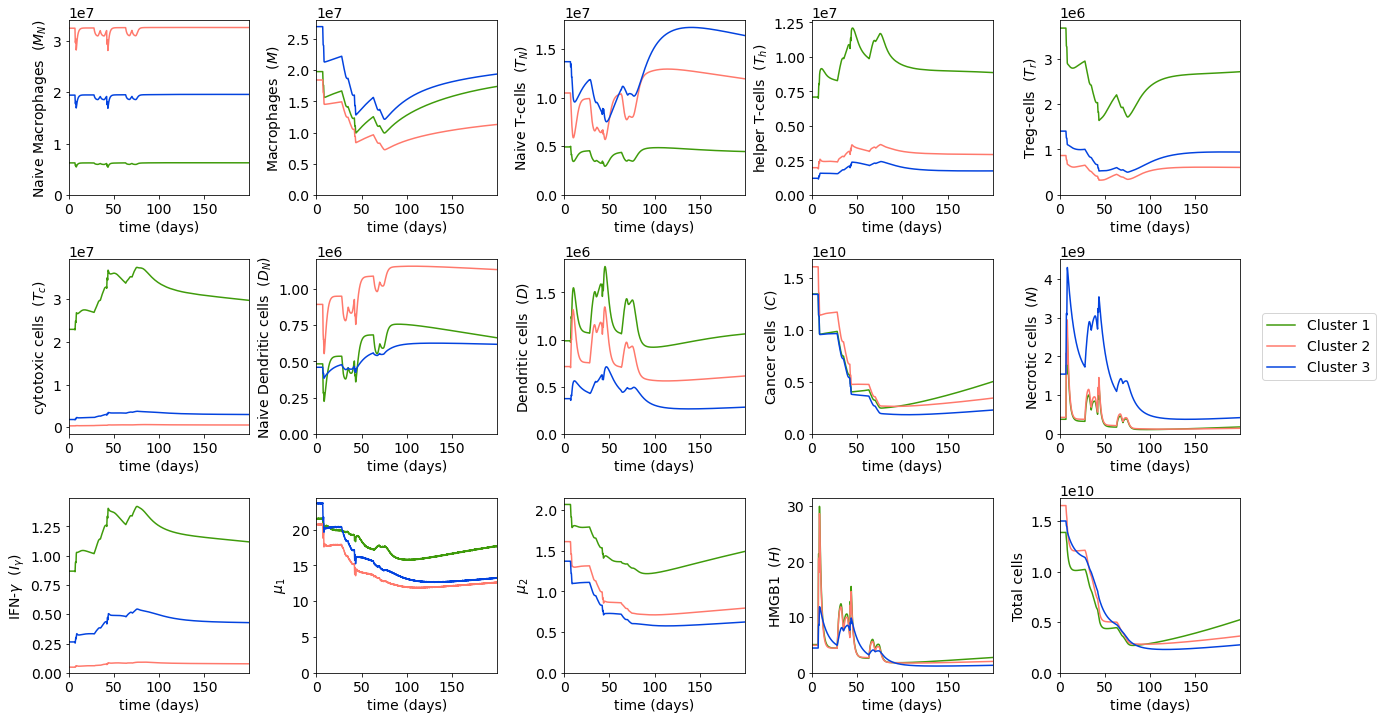

In [13]:
plot_dynamics(name='-results-CDDP-resistant-', cutoff=200, savefig=True, figname='Dynamics_CDDP_resistant')

#### DOX+CDDP-resistant

In [10]:
#Computations of dynamics
print('Starting dynamics computations')


betasI = [2.4780, 1.8328, 0.1467]
betasC = [2.4780, 0.2845, 0.0133]
K_C = 0.9
K_immune = 0.6
a = 16
alphaNCA = 0.8
deltaCTcA3_scale = 1


for cluster in range(clusters):
    print('Starting computations for cluster '+str(cluster+1)) 
    filename='Cluster-'+str(cluster+1)+'-results-DOX-CDDP-resistant-'

    QSP0=QSP.from_cell_data(clustercells[cluster], meanvals[cluster])
    qspcore=OS_MAP_resistant_Functions(parameters=QSP0.par)
    deltaCTcA3 = QSP0.par[37]*deltaCTcA3_scale
    print(QSP0.par[37], deltaCTcA3)
    QSP_=QSP.from_data(([drug_deltas, betasI, betasC, K_C, K_immune, a, alphaNCA, deltaCTcA3, drug_dose, clustercells[cluster]]), qspcore=qspcore)
    
    print(' Parameters set. Computing the solution')

    u, _ = QSP_.solve_ode(t, IC[cluster], 'given', inhomogeneity=r, jumps=True)
    # Add last 3 equations scaling value
    scale = np.concatenate([clustercells[cluster], np.array(drug_dose)/np.array(drug_deltas)])
    u = scale*u
    
    wr=np.empty((t.size, 18))
    wr[:,0]=t
    wr[:,1:]=u 
    c=csv.writer(open('Results/All_Dynamic/'+filename+'dat.csv',"w")) 
    c.writerow(['time (days)']+QSP_.variable_names())
    c.writerows(wr)
    del c


Starting dynamics computations
Starting computations for cluster 1
0.012269443384292386 0.012269443384292386
 Parameters set. Computing the solution


C:\Users\Trang Le\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Starting computations for cluster 2
0.009657389749427571 0.009657389749427571
 Parameters set. Computing the solution
Starting computations for cluster 3
0.008401675631568845 0.008401675631568845
 Parameters set. Computing the solution


Cancer population left:  800    3.886377e+09
Name: Cancer cells  ($C$), dtype: float64
Cancer population left:  800    4.408563e+09
Name: Cancer cells  ($C$), dtype: float64
Cancer population left:  800    3.294003e+09
Name: Cancer cells  ($C$), dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


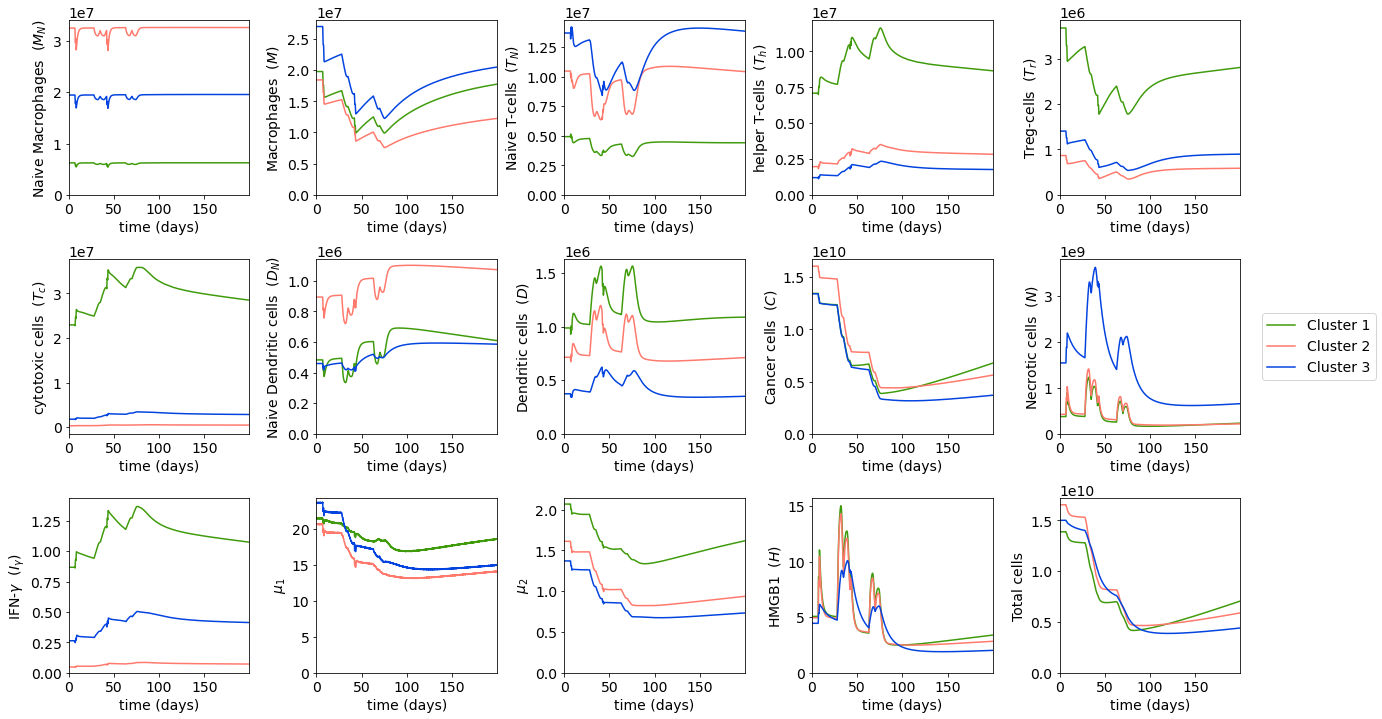

In [11]:
plot_dynamics(name='-results-DOX-CDDP-resistant-', cutoff=200, savefig=True, figname='Dynamics_DOX_CDDP_resistant')